## Basic library to import

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm 
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
import ipywidgets as widgets

## Specific library to import

In [62]:
# Note: does this need to be a separate cell? It looks like you need both regardless, consider combining them into one.

import discretize
import empymod


## Project package to import

In [63]:
import Project
from Project import EMIP1D
from Project import psuedolog

In [64]:
# Configuration is inspired by JOGMEC WISTEM survey
# K.Nakayama(2014)
t = np.logspace(-5,-2, 61)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]*1e3

In [65]:
res_air = 2e14
res_sea = 1/3
nlayers = 5
layer_thicknesses = 10
seabed_depth = 1000.1

btm_fix = False
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers)])

Configuration is inspired by JOGMEC WISTEM survey  
In this case I am using bipole so excactly as 3.5m rectangular loop  
K.Nakayama(2019)  

In [66]:

model_base = {
    'src':  [1.75,1.75,-1.75,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [67]:
EMIP =  EMIP1D(IP_model="pelton",model_base=model_base, 
res_air=res_air,res_sea=res_sea, nlayers=nlayers, tindex=tindex,
cmax=0.7)

In [68]:
res    = np.r_[ 1. ,  0.2,  0.2,  1.0, 1.0]
mvec_r = np.log(res)
mvec_m = np.r_[ 0.0,  0.3,  0.3,  0.0, 0.0]
tau    = np.r_[1e-3, 3e-3, 3e-3, 1e-3, 1e-3]
mvec_t = np.log(tau)
mvec_c = np.r_[ 0.5,  0.6, 0.6,  0.5, 0.5]

mvec_obs = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
data_clean = EMIP.predicted_data(mvec_obs)

In [69]:
model_obs = EMIP.get_ip_model(mvec_obs)
np.set_printoptions(formatter={'float': lambda x: "{:.2e}".format(x)})
print(f'{model_obs["res"]:}')
print(f'{model_obs["m"]}')
print(f'{model_obs["tau"]}')
print(f'{model_obs["c"]}')

[2.00e+14 3.33e-01 1.00e+00 2.00e-01 2.00e-01 1.00e+00 1.00e+00]
[0.00e+00 0.00e+00 0.00e+00 3.00e-01 3.00e-01 0.00e+00 0.00e+00]
[1.00e-03 1.00e-03 1.00e-03 3.00e-03 3.00e-03 1.00e-03 1.00e-03]
[5.00e-01 5.00e-01 5.00e-01 6.00e-01 6.00e-01 5.00e-01 5.00e-01]


Add gaussian noise

In [70]:
relative_error=0.01
#relative_error=0.0
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

Prepare initial model

In [71]:
res = np.ones(nlayers)
mvec_r = np.log(res)
mvec_m = 0.0* np.ones(nlayers)
mvec_t = np.log(1e-3)*np.ones(nlayers)
mvec_c = 0.5*np.ones(nlayers)
mvec_init = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
data_init = EMIP.predicted_data(mvec_init)


In [72]:
# res    = np.r_[ 1.0,  0.2,  0.2,  0.2, 1.0]
# mvec_r = np.log(res)
# mvec_m = np.r_[ 0.0,  0.3,  0.3,  0.3, 0.0]
# tau    = np.r_[1e-3, 3e-3, 3e-3, 3e-3, 1e-3]
# mvec_t = np.log(tau)
# mvec_c = np.r_[ 0.5,  0.6, 0.6,  0.6, 0.5]
# mvec_init = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
# data_init = EMIP.predicted_data(mvec_init)

In [73]:
EMIP.set_Wd(dobs=data_obs,dp=1,ratio=0.01,plateau=1e-5)
# EMIP.set_Wd(dobs=data_obs,dp=0,ratio=0.01,plateau=0)
EMIP.set_Ws()
EMIP.set_Wx()

Wd = EMIP.get_Wd(dobs=data_obs,dp=1,ratio=0.01,plateau=1e-5)
Ws = EMIP.get_Ws()
Wx = EMIP.get_Wx()

# Wd = EMIP.get_Wd(dobs=data_obs,dp=0,ratio=0.01,plateau=0)
# plt.colorbar(plt.matshow(Wx), norm=LogNorm())


Inversion using GaussNewton method

In [74]:
niter = 20
beta = 1e-2
alphas = 1
alphax = 100
stol= 1e-3
mu = -0.1
mvec_pred, error, mvec_itr = EMIP.GaussNewton_smooth(
    dobs=data_obs, mvec_init=mvec_init, niter=niter, 
    beta=beta, alphas=alphas, alphax=alphax,
    stol=stol,mu=mu
)
# mvec_pred, error, mvec_itr = EMIP.GaussNewton_Reg_LS(
#     dobs=data_obs, model_init=mvec_init, niter=niter,beta=beta,
#     atol=1e-14, mu= 1e-4
# )


Gauss-Newton 
 Initial phid = 2.36e+03 ,phim = 0.00e+00, error= 2.36e+03 
  1, step:1.00e+00, gradient:8.71e+03, phid:1.58e+02, phim:7.84e+02, f:1.66e+02 
  2, step:1.00e+00, gradient:1.33e+03, phid:3.95e+01, phim:2.53e+02, f:4.21e+01 
  3, step:5.00e-01, gradient:7.83e+02, phid:2.72e+01, phim:1.83e+02, f:2.91e+01 
  4, step:5.00e-01, gradient:9.70e+02, phid:2.47e+01, phim:1.71e+02, f:2.64e+01 
  5, step:5.00e-01, gradient:1.17e+03, phid:2.02e+01, phim:1.43e+02, f:2.16e+01 
  6, step:9.77e-04, gradient:7.66e+02, phid:2.02e+01, phim:1.43e+02, f:2.16e+01 
  7, step:9.77e-04, gradient:7.67e+02, phid:2.02e+01, phim:1.43e+02, f:2.17e+01 
  8, step:9.77e-04, gradient:7.68e+02, phid:2.03e+01, phim:1.43e+02, f:2.17e+01 
  9, step:9.77e-04, gradient:7.69e+02, phid:2.03e+01, phim:1.42e+02, f:2.17e+01 
 10, step:9.77e-04, gradient:7.70e+02, phid:2.03e+01, phim:1.42e+02, f:2.17e+01 
 11, step:9.77e-04, gradient:7.71e+02, phid:2.03e+01, phim:1.42e+02, f:2.18e+01 
 12, step:9.77e-04, gradient:7.72e+

In [75]:
data_pred = (EMIP.predicted_data(mvec_pred))
cmp_itr = len(error)
data_itr = np.zeros((cmp_itr,len(data_pred)))
for i, mvec_tmp in enumerate(mvec_itr):
    data_itr[i,:] = EMIP.predicted_data(mvec_tmp)


In [76]:
def plot_inversion_results_widget(ind_show):
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 4)  
    ax = [None] * 6

    ax[0] = fig.add_subplot(gs[0, 0])
    ax[1] = fig.add_subplot(gs[0, 1])
    ax[2] = fig.add_subplot(gs[1, 0])
    ax[3] = fig.add_subplot(gs[1, 1])
    ax[4] = fig.add_subplot(gs[0, 2:])
    ax[5] = fig.add_subplot(gs[1, 2:])

    axip =[ax[0], ax[1], ax[2], ax[3]]
    axip = EMIP.plot_IP_par(mvec=mvec_init, label="initial model", color="k-",  ax=axip, linewidth=3.0)
    axip = EMIP.plot_IP_par(mvec=mvec_obs,  label="true model",    color="b-",  ax=axip, linewidth=3.0)
    axip = EMIP.plot_IP_par(mvec=mvec_itr[ind_show], label="predicted model",color="r--",ax=axip, linewidth=3.0)
    ax[0].set_xlim([1.1,0.09])

    for i in range(2):
        tr_min, tr_max = ax[2*i].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i].semilogx(tr_z, model_base["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
    for i in range(2):
        tr_min, tr_max = ax[2*i+1].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i+1].plot(tr_z, model_base["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
        
    a = 1e-4
    b = 0.2
    posmax = 10**(np.log10(max(np.r_[a/10,  data_obs,  data_init]) ) // 1 +1)
    negmax = 10**(np.log10(max(np.r_[a/10, -data_obs, -data_init]) ) // 1 +1)
    data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
    ax[4] = data_plot.pl_plot(tplot, data_init, ax=ax[4], color="k", label="initial")
    ax[4] = data_plot.pl_plot(tplot, data_obs , ax=ax[4], color="b", label="observation")
    ax[4] = data_plot.pl_scatter(tplot, data_itr[ind_show], ax=ax[4], marker="o",s=10,color="r", label="prediction")
    ax[4] = data_plot.pl_axes(ax[4])
    ax[4].set_title("Data for each model")
    ax[4].set_ylabel("dbdt")
    ax[4].legend()
    ax[4].set_xlabel("time(msec)")

    ax[5].semilogy(error,label="error value",color='black')
    ax[5].semilogy(ind_show,error[ind_show],"o",label="index", color="red")
    ax[5].semilogy(np.arange(cmp_itr), np.ones(cmp_itr) * tindex.shape[0],"--k", label="phid_target")
    ax[5].set_title("Inversion Progress")
    ax[5].set_ylabel("Error value")
    ax[5].legend()
    ax[5].grid()
    ax[5].set_xlabel("iteration")


    for i in range(4):  # Iterate over rows
        ax[i].set_ylim([1050, 990])
        ax[i].set_ylabel('depth')
     #   ax[i].legend()
        ax[i].grid()
        if i== 0 or i ==2:
            ax[i].set_xscale("log")
        else:
            ax[i].set_xscale("linear")

    plt.tight_layout()

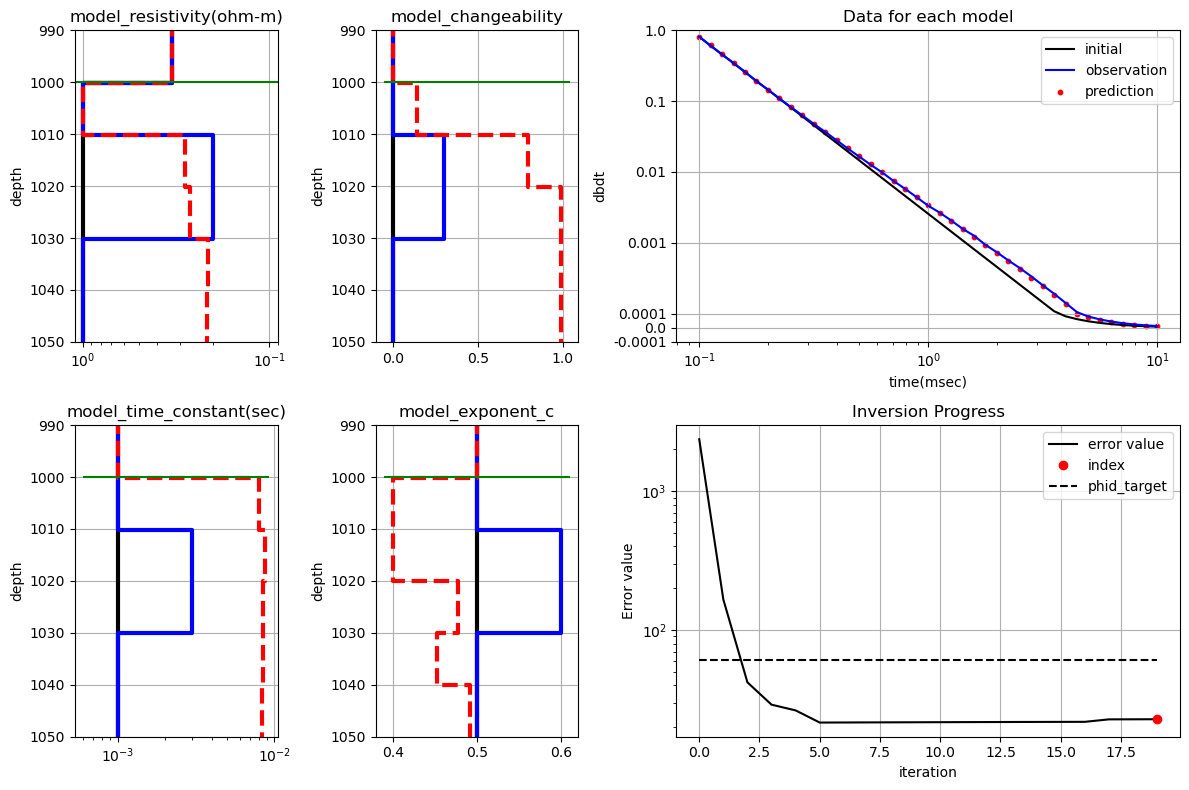

In [77]:
plot_inversion_results_widget(cmp_itr-1)
plt.savefig("5_multilayer_pelton_0mh_ModelData.png",dpi=300)
plt.show()

In [78]:
widgets.interact(plot_inversion_results_widget, 
ind_show= widgets.IntSlider(min=0,max=cmp_itr-1,value=0))

interactive(children=(IntSlider(value=0, description='ind_show', max=19), Output()), _dom_classes=('widget-int…

<function __main__.plot_inversion_results_widget(ind_show)>

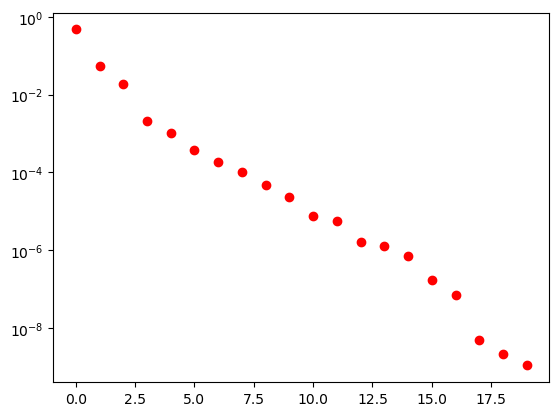

In [79]:
## Check SVD of Jacobian
J = EMIP.Jacobian
UJ, SJ, VJh = np.linalg.svd(J,full_matrices=False,)
plt.semilogy(SJ,'ro')


Condition number of Hessian: 3.73e+06


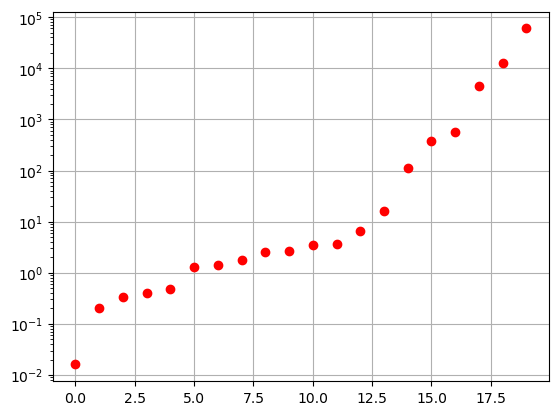

In [80]:
## Calculate Equivalent model
H = EMIP.Hessian
HV, HU = np.linalg.eigh(H)
#HV, HU = np.linalg.eigh(J.T @ J)
# Calculate condition number and plot Eigenvalues
print(f'Condition number of Hessian: {HV[-1]/HV[0]:.2e}')
plt.semilogy(HV,'ro')
plt.grid()

In [81]:
ind_eigen = 0
error_bound = 0.01
rmax = np.sqrt(2* error_bound*error[cmp_itr-1]/ HV[ind_eigen])
dm = HU[:,ind_eigen]
n_interv = 20
error_eqv = np.zeros(n_interv+1)
mvec_eqv = np.zeros((n_interv+1,len(mvec_pred)))
rate = np.zeros(n_interv+1)
data_eqv = np.zeros((n_interv+1,len(data_pred)))
for i in range(n_interv+1):
    rate[i] = - ((n_interv-i)/n_interv) *rmax + (i/n_interv)*rmax 
    mvec_eqv[i,:] = mvec_pred + rate[i] * dm
    data_eqv[i,:] = EMIP.predicted_data( mvec_eqv[i,:])
    rd = Wd @ (data_eqv[i,:] - data_obs)
    phid = 0.5 * np.dot(rd, rd)
    rms = 0.5 * np.dot(Ws @ (mvec_eqv[i,:] - mvec_init),
                        Ws @ (mvec_eqv[i,:] - mvec_init))
    rmx = 0.5 * np.dot(Wx @ mvec_eqv[i,:], Wx @ mvec_eqv[i,:])
    phim = alphas * rms + alphax * rmx
    error_eqv[i] = phid + beta * phim


In [82]:
def plot_equivalent_model_widget(ind_show):
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 4)  
    ax = [None] * 6

    ax[0] = fig.add_subplot(gs[0, 0])
    ax[1] = fig.add_subplot(gs[0, 1])
    ax[2] = fig.add_subplot(gs[1, 0])
    ax[3] = fig.add_subplot(gs[1, 1])
    ax[4] = fig.add_subplot(gs[0, 2:])
    ax[5] = fig.add_subplot(gs[1, 2:])

    axip =[ax[0], ax[1], ax[2], ax[3]]
    axip = EMIP.plot_IP_par(mvec=mvec_init, label="initial model", color="k-",  ax=axip, linewidth=3.0)
    axip = EMIP.plot_IP_par(mvec=mvec_obs,  label="true model",    color="b-",  ax=axip, linewidth=3.0)
    axip = EMIP.plot_IP_par(mvec=mvec_eqv[ind_show], label="equivalent model",color="r--",ax=axip, linewidth=3.0)
    ax[0].set_xlim([1.1, 0.09])


    for i in range(2):
        tr_min, tr_max = ax[2*i].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i].semilogx(tr_z, model_base["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
    for i in range(2):
        tr_min, tr_max = ax[2*i+1].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i+1].plot(tr_z, model_base["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
    
    a = 1e-4
    b = 0.2
    posmax = 10**(np.log10(max(np.r_[a/10,  data_obs,  data_init]) ) // 1 +1)
    negmax = 10**(np.log10(max(np.r_[a/10, -data_obs, -data_init]) ) // 1 +1)
    data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
    ax[4] = data_plot.pl_plot(tplot, data_init, ax=ax[4], color="k", label="initial")
    ax[4] = data_plot.pl_plot(tplot, data_obs , ax=ax[4], color="b", label="observation")
    ax[4] = data_plot.pl_scatter(tplot, data_eqv[ind_show], ax=ax[4], marker="o",s=10,color="r", label="prediction")
    ax[4] = data_plot.pl_axes(ax[4])
    ax[4].set_title("Data for each model")
    ax[4].set_ylabel("dbdt")
    ax[4].legend()
    ax[4].set_xlabel("time(msec)")

    ax[5].plot(rate,error_eqv,label="error value",color='black')
    ax[5].plot(rate[ind_show],error_eqv[ind_show],"o",label="index", color="red")
    ax[5].set_title("ErrorValue")
    ax[5].set_xlabel("r: mvec_eqv = r*eigenvector + mvec_pred")
    ax[5].set_ylabel("Error value")
    ax[5].legend()
    ax[5].grid()


    for i in range(4):  # Iterate over rows
        ax[i].set_ylim([1050, 990])
        ax[i].set_ylabel('depth')
     #   ax[i].legend()
        ax[i].grid()
        if i== 0 or i ==2:
            ax[i].set_xscale("log")
        else:
            ax[i].set_xscale("linear")

    plt.tight_layout()

In [83]:
widgets.interact(plot_equivalent_model_widget, 
    ind_show= widgets.IntSlider(min=0,max=n_interv,value=0))

interactive(children=(IntSlider(value=0, description='ind_show', max=20), Output()), _dom_classes=('widget-int…

<function __main__.plot_equivalent_model_widget(ind_show)>

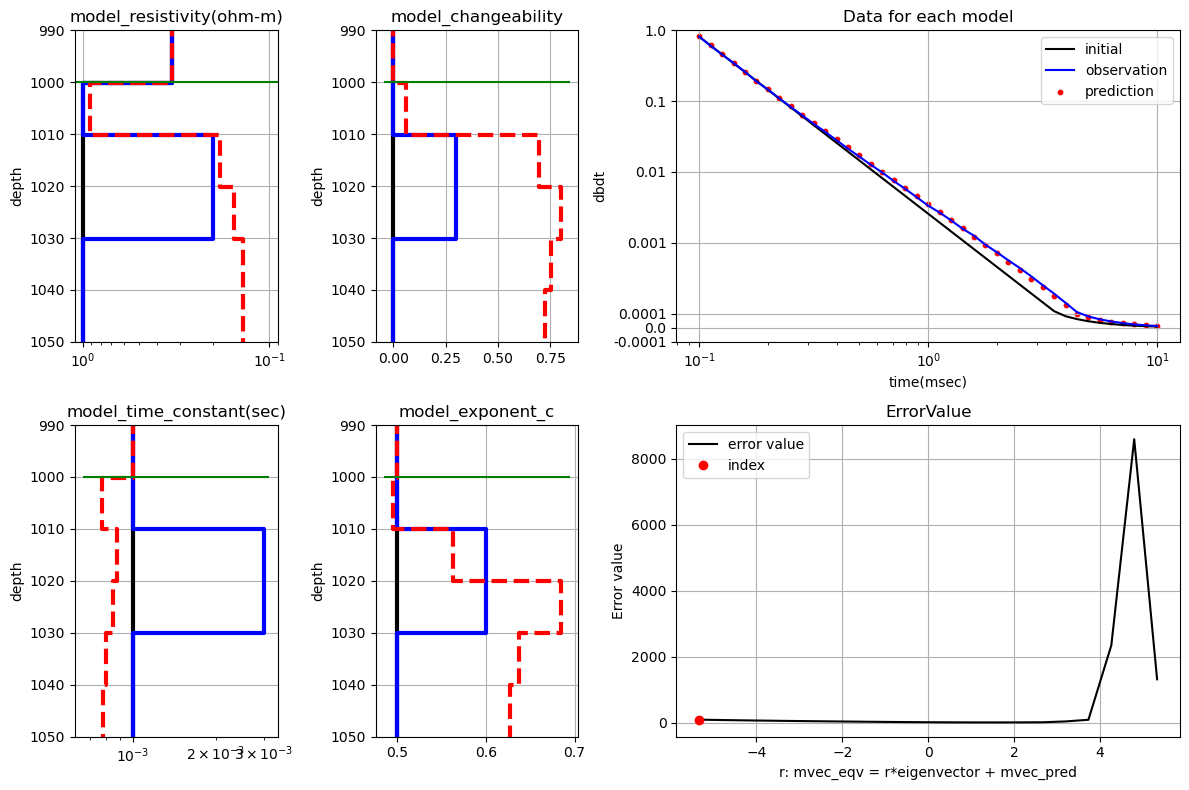

In [84]:
plot_equivalent_model_widget(0)
plt.savefig("5_multilayer_pelton_0mh_EquivalentModel_1.png",dpi=300)
plt.show()

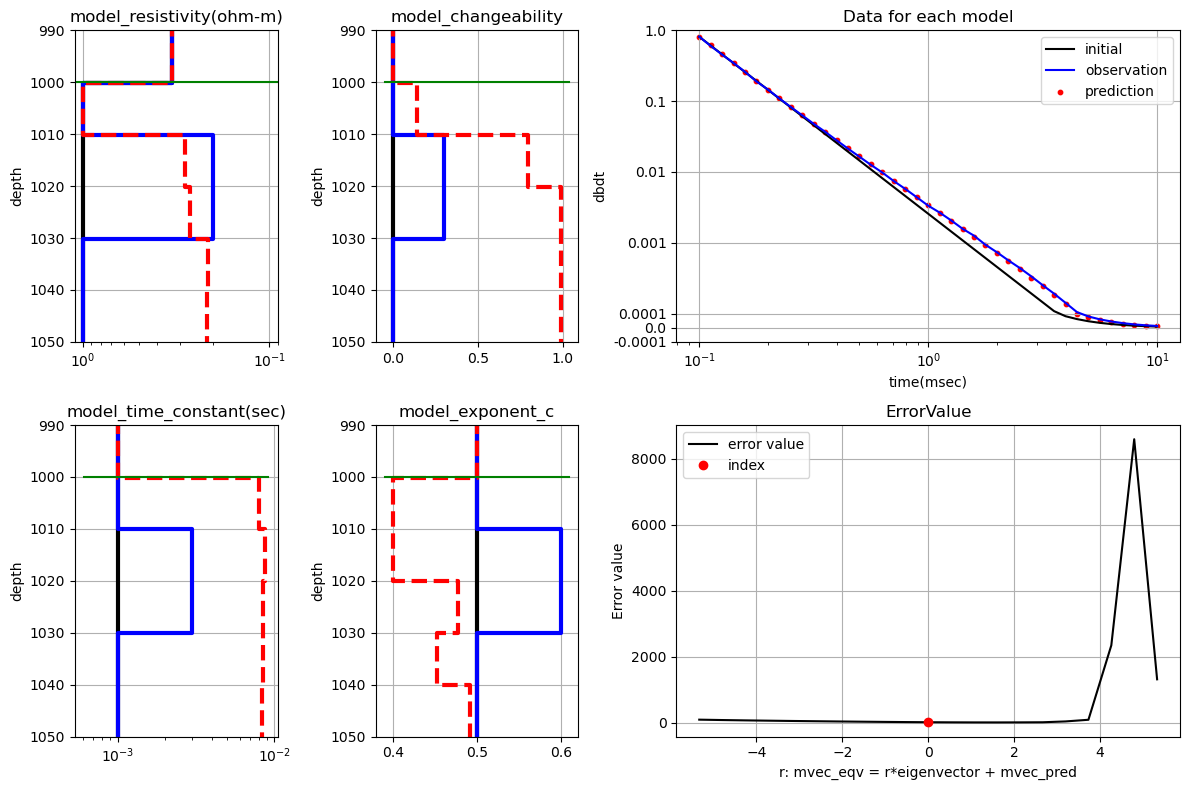

In [85]:
plot_equivalent_model_widget(int(n_interv/2))

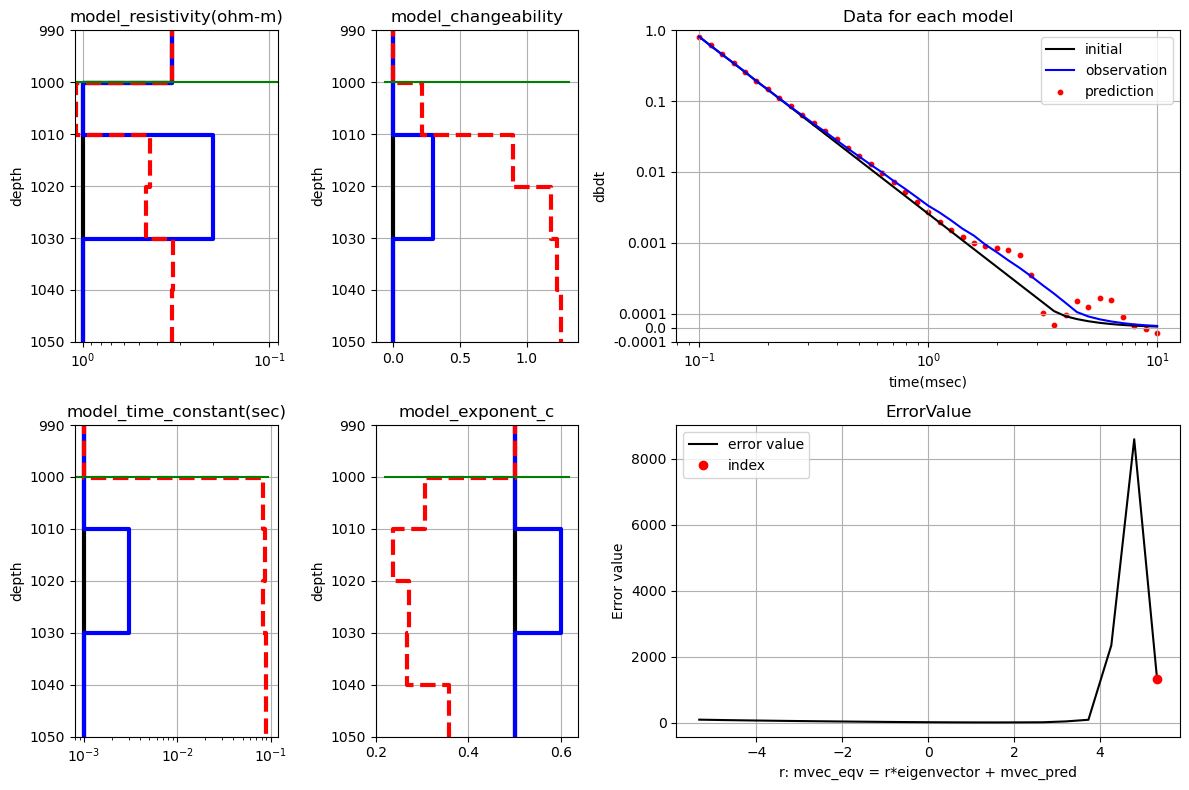

In [86]:
plot_equivalent_model_widget(n_interv)
plt.savefig("5_multilayer_pelton_0mh_EquivalentModel_2.png",dpi=300)
plt.show()